In [326]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [128]:
df = pd.read_csv("stock_prices.csv", nrows=300000) # As the entire dataset cannot be read on computers with low processing power, we have to limit the number of rows we are reading
df.head()

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


In [129]:
df.isna().sum()

symbol               0
date                 0
open                 0
high                 0
low                  0
close                0
close_adjusted       0
volume               0
split_coefficient    0
dtype: int64

We can see that there are no null values present in the dataset. However, we should also check datetime columns (date) to ensure that there are no arbitrary values such as 9999-99-99 (generally used to indicate a time that has no ended yet)

In [130]:
df['date'] = pd.to_datetime(df['date'])

Converting the date column into days from the starting date as the Gaussian Mixture Model cannot handle datetime format

In [131]:
df['date'] = df['date'] - df['date'].min()

In [132]:
df['date'].max().days

6596

In [133]:
df.head()

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,5978 days,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,744 days,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,624 days,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2853 days,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,5289 days,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


In [134]:
df['date'] = df['date'].dt.days

In [135]:
df.head()

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,5978,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,744,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,624,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2853,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,5289,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


In [274]:
train_date = df['date'].quantile(0.7)
train_date

5386.0

In [339]:
train_df = df[df['date'] <= train_date]
test_df = df[df['date'] > train_date]

In [340]:
cutoff_date = train_df['date'].median()
cutoff_date

3223.0

Splitting the dataset into labelled and unlabelled sets based on the cutoff date (taken as median date in the dataset). As we are trying to find the close price (adjusted after paying dividends).

In [341]:
labelled_data = train_df[train_df['date'] <= cutoff_date].drop('close_adjusted', axis=1)
labelled_labels = train_df[train_df['date'] <= cutoff_date]['close_adjusted']
unlabelled_data = train_df[train_df['date'] > cutoff_date].drop('close_adjusted', axis=1)

In [342]:
labelled_data.shape

(105065, 8)

In [343]:
labelled_labels.shape

(105065,)

In [344]:
unlabelled_data.shape

(104998, 8)

We must make sure the datasets are equal, as such we will remove the last couple records of the labelled_data and labelled_labels

In [345]:
idx = unlabelled_data.shape[0] - labelled_data.shape[0]
idx

-67

In [346]:
labelled_data = labelled_data.iloc[:idx]
labelled_labels = labelled_labels.iloc[:idx]

In [347]:
labelled_data.shape

(104998, 8)

In [348]:
labelled_labels.shape

(104998,)

In [349]:
unlabelled_data.shape

(104998, 8)

In [350]:
encoder = LabelEncoder()
labelled_data['symbol'] = encoder.fit_transform(labelled_data['symbol'])
unlabelled_data['symbol'] = encoder.fit_transform(unlabelled_data['symbol'])

In [351]:
labelled_data.head()

,symbol,date,open,high,low,close,volume,split_coefficient
1,63,744,68.85,69.84,67.85,67.87,30977700,1.0
2,63,624,53.41,55.00,53.17,54.32,41591300,1.0
3,63,2853,36.01,36.03,34.56,35.03,288121200,1.0
7,63,126,70.94,71.37,69.69,69.81,18093800,1.0
12,63,1494,27.06,27.17,26.83,26.96,55527500,1.0


In [352]:
labelled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104998 entries, 1 to 299461
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   symbol             104998 non-null  int32  
 1   date               104998 non-null  int64  
 2   open               104998 non-null  float64
 3   high               104998 non-null  float64
 4   low                104998 non-null  float64
 5   close              104998 non-null  float64
 6   volume             104998 non-null  int64  
 7   split_coefficient  104998 non-null  float64
dtypes: float64(5), int32(1), int64(2)
memory usage: 6.8 MB


Now let us define the pipeline of our semi-supervised algorithm.

1. Train the unsupervised model (Gaussian Mixture Model) on the labelled data
2. Predict the labels for the unlabelled data using the trained model from step 1
3. Make a new dataset containing labels for the unlabelled data
4. Train a supervised model (Logistic Regression) on the combined dataset of labelled data and the newly created dataset
5. To predict any unseen test case, we simply predict the label using our unsupervised model and then predict the close_adjusted price using our logistic regression model

There is no need to split the labelled_data into a training and testing dataset as it alone acts as a training dataset for our unsupervised model

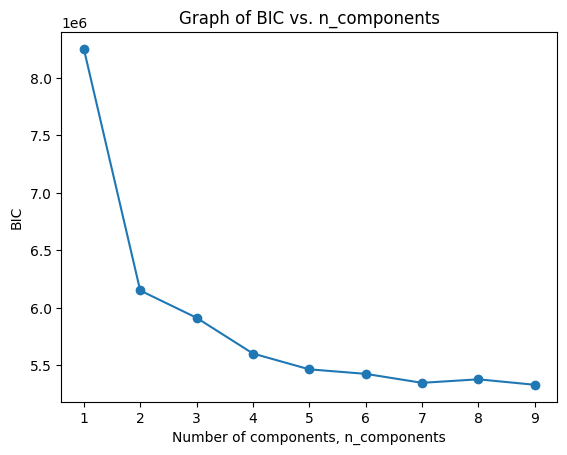

In [353]:
# Identifying the best hyperparameters using the Bayesian Information Criterion (BIC) to evaluate our Gaussian Mixture Model
n_components_range = range(1, 10)

bic = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(labelled_data)
    bic.append(gmm.bic(labelled_data))

# Plotting the data to identify any elbow curve
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of components, n_components')
plt.ylabel('BIC')
plt.title('Graph of BIC vs. n_components')
plt.show()

Choosing n_components as 3 according to the elbow method

In [354]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(labelled_data)

GaussianMixture(n_components=3)

Predicting the cluster labels of the unlabelled data

In [355]:
unlabelled_labels = gmm.predict(unlabelled_data)

In [356]:
unlabelled_labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

Training the LogisticRegression model using the labelled data and the cluster labels

In [357]:
unlabelled_labels.shape

(104998,)

In [358]:
labelled_data.shape

(104998, 8)

In [359]:
X = np.vstack((labelled_data.T, unlabelled_labels))
y = np.hstack((labelled_labels))

In [360]:
print(X.shape)
print(y.shape)

(9, 104998)
(104998,)


In [362]:
rfr = RandomForestRegressor()
rfr.fit(X.T, y)

RandomForestRegressor()

In [363]:
test_df['symbol'] = encoder.fit_transform(test_df['symbol'])
predictions = rfr.predict(test_df)

C:\Users\shash\AppData\Local\Temp\ipykernel_27440\34151612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['symbol'] = encoder.fit_transform(test_df['symbol'])
c:\Users\shash\Downloads\VIT Downloads\ML\mlenv\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
pd.DataFrame({'Actual': test_df['close_adjusted'], 'Predicted': predictions})

,Actual,Predicted
0,49.7013,49.365565
8,67.8482,57.398049
11,51.9835,51.362795
19,43.8807,44.343971
22,85.7100,57.398049
...,...,...
299988,1.3800,1.404400
299989,1.6300,1.573700
299990,1.4900,1.436500
299995,5.0900,5.055500
